# 多群体视角下的情绪对股票市场的影响 - 2021级金融专硕鲍子睿 - 代码实现
本项目基于处理好的时间序列数据，展示各个章节的实验结果


## 0.代码运行环境
Stata 17,python==3.10,numpy==1.24.3,pandas==2.0.2,matplotlib==3.7.1

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import BoundaryNorm
import seaborn as sns
import re
import numpy as np

# Stata 17
sys.path.append('/Applications/Stata/utilities')
from pystata import config

config.init('mp')

## 1.数据集准备

In [18]:
df_is = pd.read_csv('../DataSets/IS-TimeSeries.csv').astype(dtype={'trade_date':str})
df_is

,Unnamed: 0,trade_date,ts_code,CON_YEAR,CON_OR,CON_NP,CON_EPS,CON_NA,CON_PB,CON_PS,...,NIPO_R,RIPO_R,SR_R,l1_TURN_R,lnPD_R,SENT_INDEX_R,SENT_INDEX_EX,SENT_INDEX_DEX,SENT_INDEX_R_EX,SENT_INDEX_R_DEX
0,7,20140102,000985.SH,2014,3.034892e+09,27421.678403,0.6857,2.017385e+09,1.3334,0.8863,...,-0.993200,-0.429099,15.745780,-0.003943,-0.208500,-1.191905,-0.571980,-0.588495,-0.435412,-0.451046
1,18,20140103,000985.SH,2014,3.033876e+09,27421.601209,0.6857,2.017584e+09,1.3213,0.8787,...,-0.993200,-0.429099,15.745780,-0.004333,-0.208500,-1.182604,-0.598652,-0.588830,-0.502679,-0.452930
2,29,20140106,000985.SH,2014,3.033345e+09,27412.012060,0.6854,2.027389e+09,1.2895,0.8619,...,-0.993200,-0.429099,15.745780,-0.003813,-0.208500,-1.175354,-0.623006,-0.589509,-0.563137,-0.455863
3,40,20140107,000985.SH,2014,3.028546e+09,27384.608096,0.6846,2.027386e+09,1.2917,0.8647,...,-0.993200,-0.429099,15.745780,-0.003643,-0.208500,-1.172984,-0.644795,-0.590505,-0.617575,-0.459753
4,51,20140108,000985.SH,2014,3.028892e+09,27355.547003,0.6838,2.028490e+09,1.2935,0.8663,...,-0.993200,-0.429099,15.745780,-0.004513,-0.208500,-1.185114,-0.664723,-0.591815,-0.666961,-0.464538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,21350,20211227,000985.SH,2021,6.389869e+09,53799.927579,0.7131,5.236956e+09,1.7835,1.4617,...,-0.044895,-0.374305,-2.832969,0.001832,0.097983,0.390557,1.170102,1.302731,0.960139,1.050876
1940,21361,20211228,000985.SH,2021,6.391559e+09,53788.880275,0.7129,5.237495e+09,1.7933,1.4695,...,2.955105,-0.346122,-2.832969,0.000582,0.097983,1.186737,1.127746,1.298598,0.909492,1.046500
1941,21372,20211229,000985.SH,2021,6.389955e+09,53725.674838,0.7120,5.237052e+09,1.7779,1.4571,...,-1.044895,-0.453585,-2.832969,0.000302,0.097983,0.013389,1.149856,1.293518,0.934144,1.040757
1942,21383,20211230,000985.SH,2021,6.390729e+09,53695.625032,0.7116,5.236812e+09,1.7905,1.4672,...,1.955105,-0.193822,-2.832969,0.000072,0.097983,0.972127,1.079838,1.288670,0.852272,1.035358


## 第二章 情绪指标体系

### 金融市场情绪

In [19]:
# @formatter:off

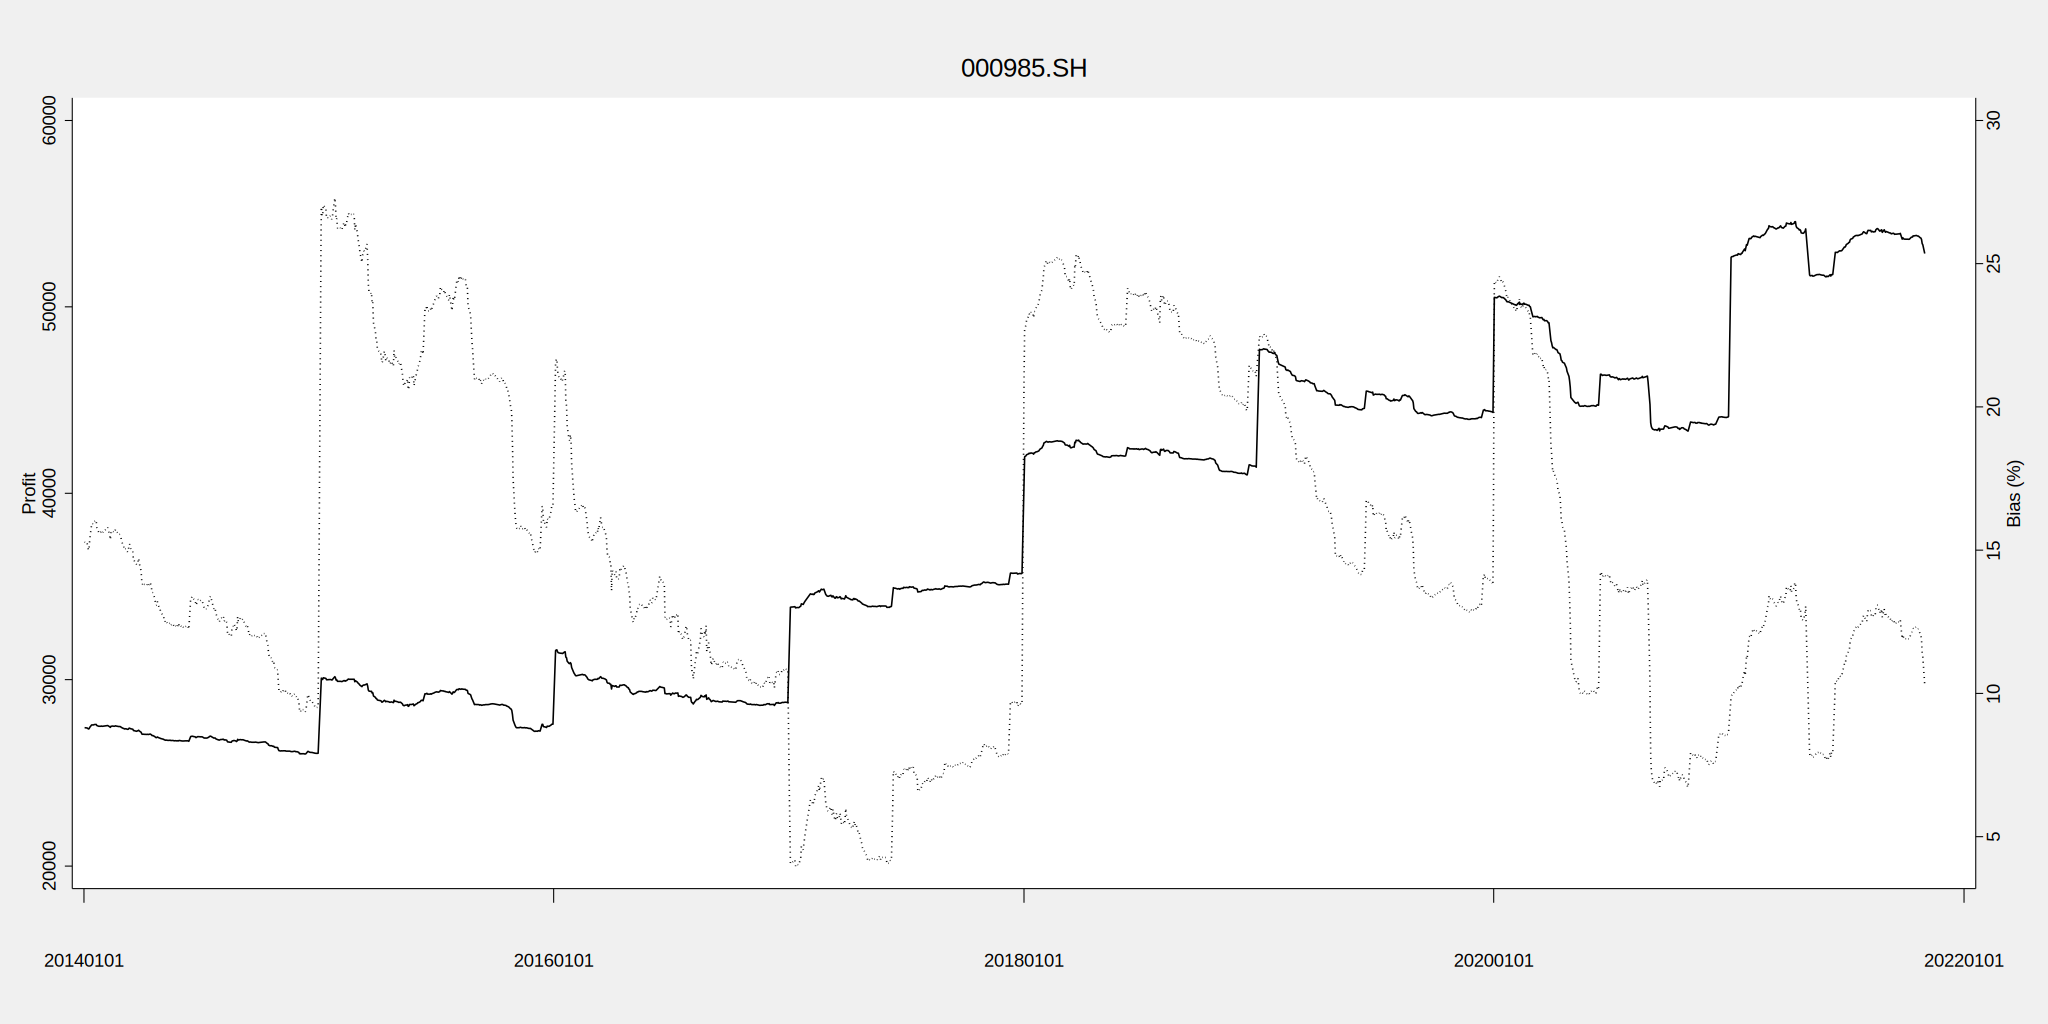

In [20]:
%%stata -d df_is -force  -qui -gw 12in -gh 6in
/*{*/
//模型设定
encode ts_code,gen(id)
ge dt = date(trade_date, "YMD")
format dt %tdCCYYNNDD
xtset id dt

//模型设定 绘图
twoway (tsline CON_NP, yaxis(1) lpattern(solid)) ///
    (tsline opt_profit, yaxis(2) lpattern(tight_dot)) if (time<=1900), ///
    ytitle(Profit ,axis(1)) ytitle("Bias (%)",axis(2))  ///
    xtitle("") legend(off) scheme(sj) xsize(10) ylabel(, nogrid) ///
    xlabel(, labgap(medium)) ///
    name(ana_sent,replace) title("000985.SH")

In [21]:
%%stata -nogr -qui
/*{*/
// 绘图
foreach var in SENT_INDEX SENT_INDEX_R SENT_INDEX_R_EX  {
    twoway (line `var' dt, yaxis(1) lpattern(solid)  lcolor(gs12)) ///
    (line close dt, yaxis(2) lpattern(solid) lcolor(gs4)) , ///
    ytitle("Sent Index" ,axis(1)) ytitle("Share Index",axis(2))  ///
    xtitle("") legend(off) scheme(sj) xsize(10) ylabel(, nogrid) ///
    xlabel(, labgap(medium)) ///
    name(code1_`var',replace) title("`var'")
}

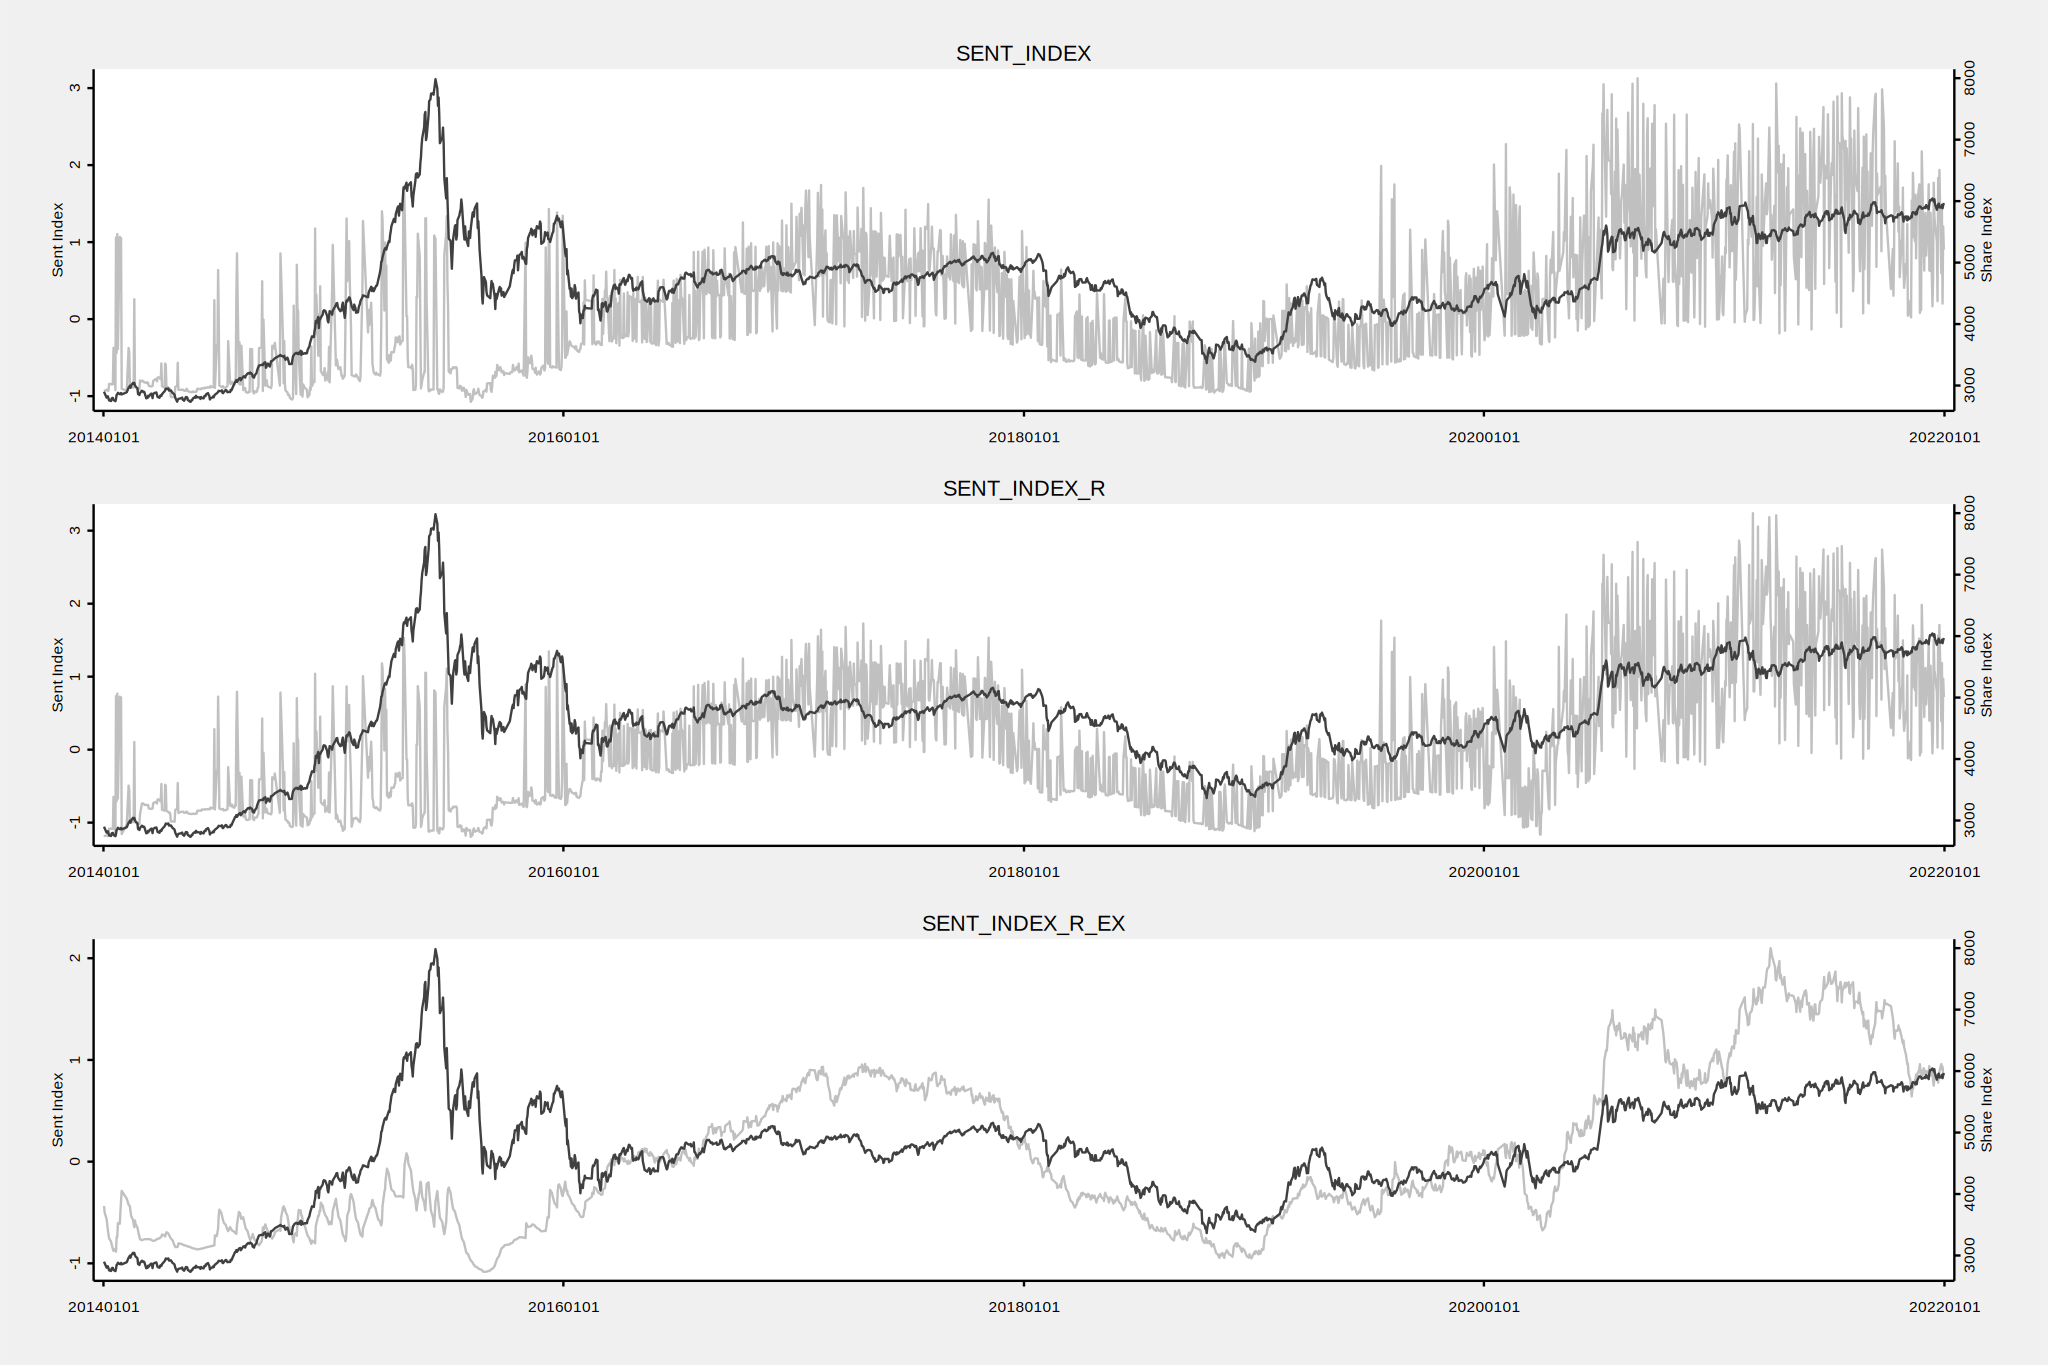

In [31]:
%%stata -gw 12in -gh 8in
graph combine code1_SENT_INDEX code1_SENT_INDEX_R code1_SENT_INDEX_R_EX , cols(1) name(c1,replace) scale(0.4) scheme(sj)

### 情绪指标相关系数矩阵

显著性检验

In [23]:
%%stata -d df_is -force
/*{*/
//清除估计结果
est clear

//生成时间变量 (已排序)
ge date=_n
tsset date

//定义待对比的指标
local independent_vars "close_chg img_neg tex_neg SENT_INDEX_EX SENT_INDEX_R_EX opt_profit"
pwcorr `independent_vars', sig
mat p_values = r(sig)
esttab mat(p_values)  using outputs/sentindex_pwcorr.csv,r nomtitle type
/*}*/


. /*{*/
. //清除估计结果
. est clear

. 
. //生成时间变量 (已排序)
. ge date=_n

. tsset date

Time variable: date, 1 to 1944
        Delta: 1 unit

. 
. //定义待对比的指标
. local independent_vars "close_chg img_neg tex_neg SENT_INDEX_EX SENT_INDEX_R_
> EX opt_profit"

. pwcorr `independent_vars', sig

             | close_~g  img_neg  tex_neg SEN~X_EX SEN~R_EX opt_pr~t
-------------+------------------------------------------------------
   close_chg |   1.0000 
             |
             |
     img_neg |   0.0106   1.0000 
             |   0.6414
             |
     tex_neg |  -0.0090   0.0485   1.0000 
             |   0.6902   0.0324
             |
SENT_IN~X_EX |  -0.0010   0.1806   0.0394   1.0000 
             |   0.9635   0.0000   0.0827
             |
SENT_IN~R_EX |  -0.0010   0.1723   0.0501   0.9711   1.0000 
             |   0.9648   0.0000   0.0272   0.0000
             |
  opt_profit |  -0.0251  -0.0342  -0.0822  -0.5391  -0.6060   1.0000 
             |   0.2690   0.1312   0.0003   0.0000   0

In [24]:
# @formatter:on

# 处理滞后时序数据
df_corr = pd.read_csv('outputs/sentindex_pwcorr.csv').replace({'=': '', '"': '', }, regex=True)
df_corr = df_corr.drop(df_corr.columns[0], axis=1)
df_corr = df_corr.applymap(lambda x: re.sub(r'^\.$', '1', str(x)))
df_corr.astype('float64').to_csv('outputs/sentindex_pwcorr_t.csv')

df = df_is[['close_chg', 'img_neg', 'tex_neg', 'SENT_INDEX_EX', 'SENT_INDEX_R_EX', 'opt_profit']].copy()
df['close_chg'] = df['close_chg'].shift(-1)
df.rename(
    columns={'close_chg': 'Return_t+1', 'img_neg': 'Media_img', 'tex_neg': 'Media_text', 'SENT_INDEX_EX': 'PCA', 'SENT_INDEX_R_EX': 'PCA_R',
             'opt_profit': 'Analyst'}, inplace=True)
df

,Return_t+1,Media_img,Media_text,PCA,PCA_R,Analyst
0,-0.907044,0.000000,0.000000,-0.571980,-0.435412,15.279813
1,-2.471193,0.000000,0.333333,-0.598652,-0.502679,15.279489
2,0.385618,0.285714,0.142857,-0.623006,-0.563137,15.239177
3,0.416474,0.000000,0.333333,-0.644795,-0.617575,15.123971
4,-1.143739,0.333333,0.000000,-0.664723,-0.666961,15.001799
...,...,...,...,...,...,...
1939,0.716572,0.220339,0.152542,1.170102,0.960139,12.253340
1940,-0.910999,0.047619,0.238095,1.127746,0.909492,12.230290
1941,0.848972,0.250000,0.350000,1.149856,0.934144,12.098412
1942,0.581746,0.388889,0.277778,1.079838,0.852272,12.035713


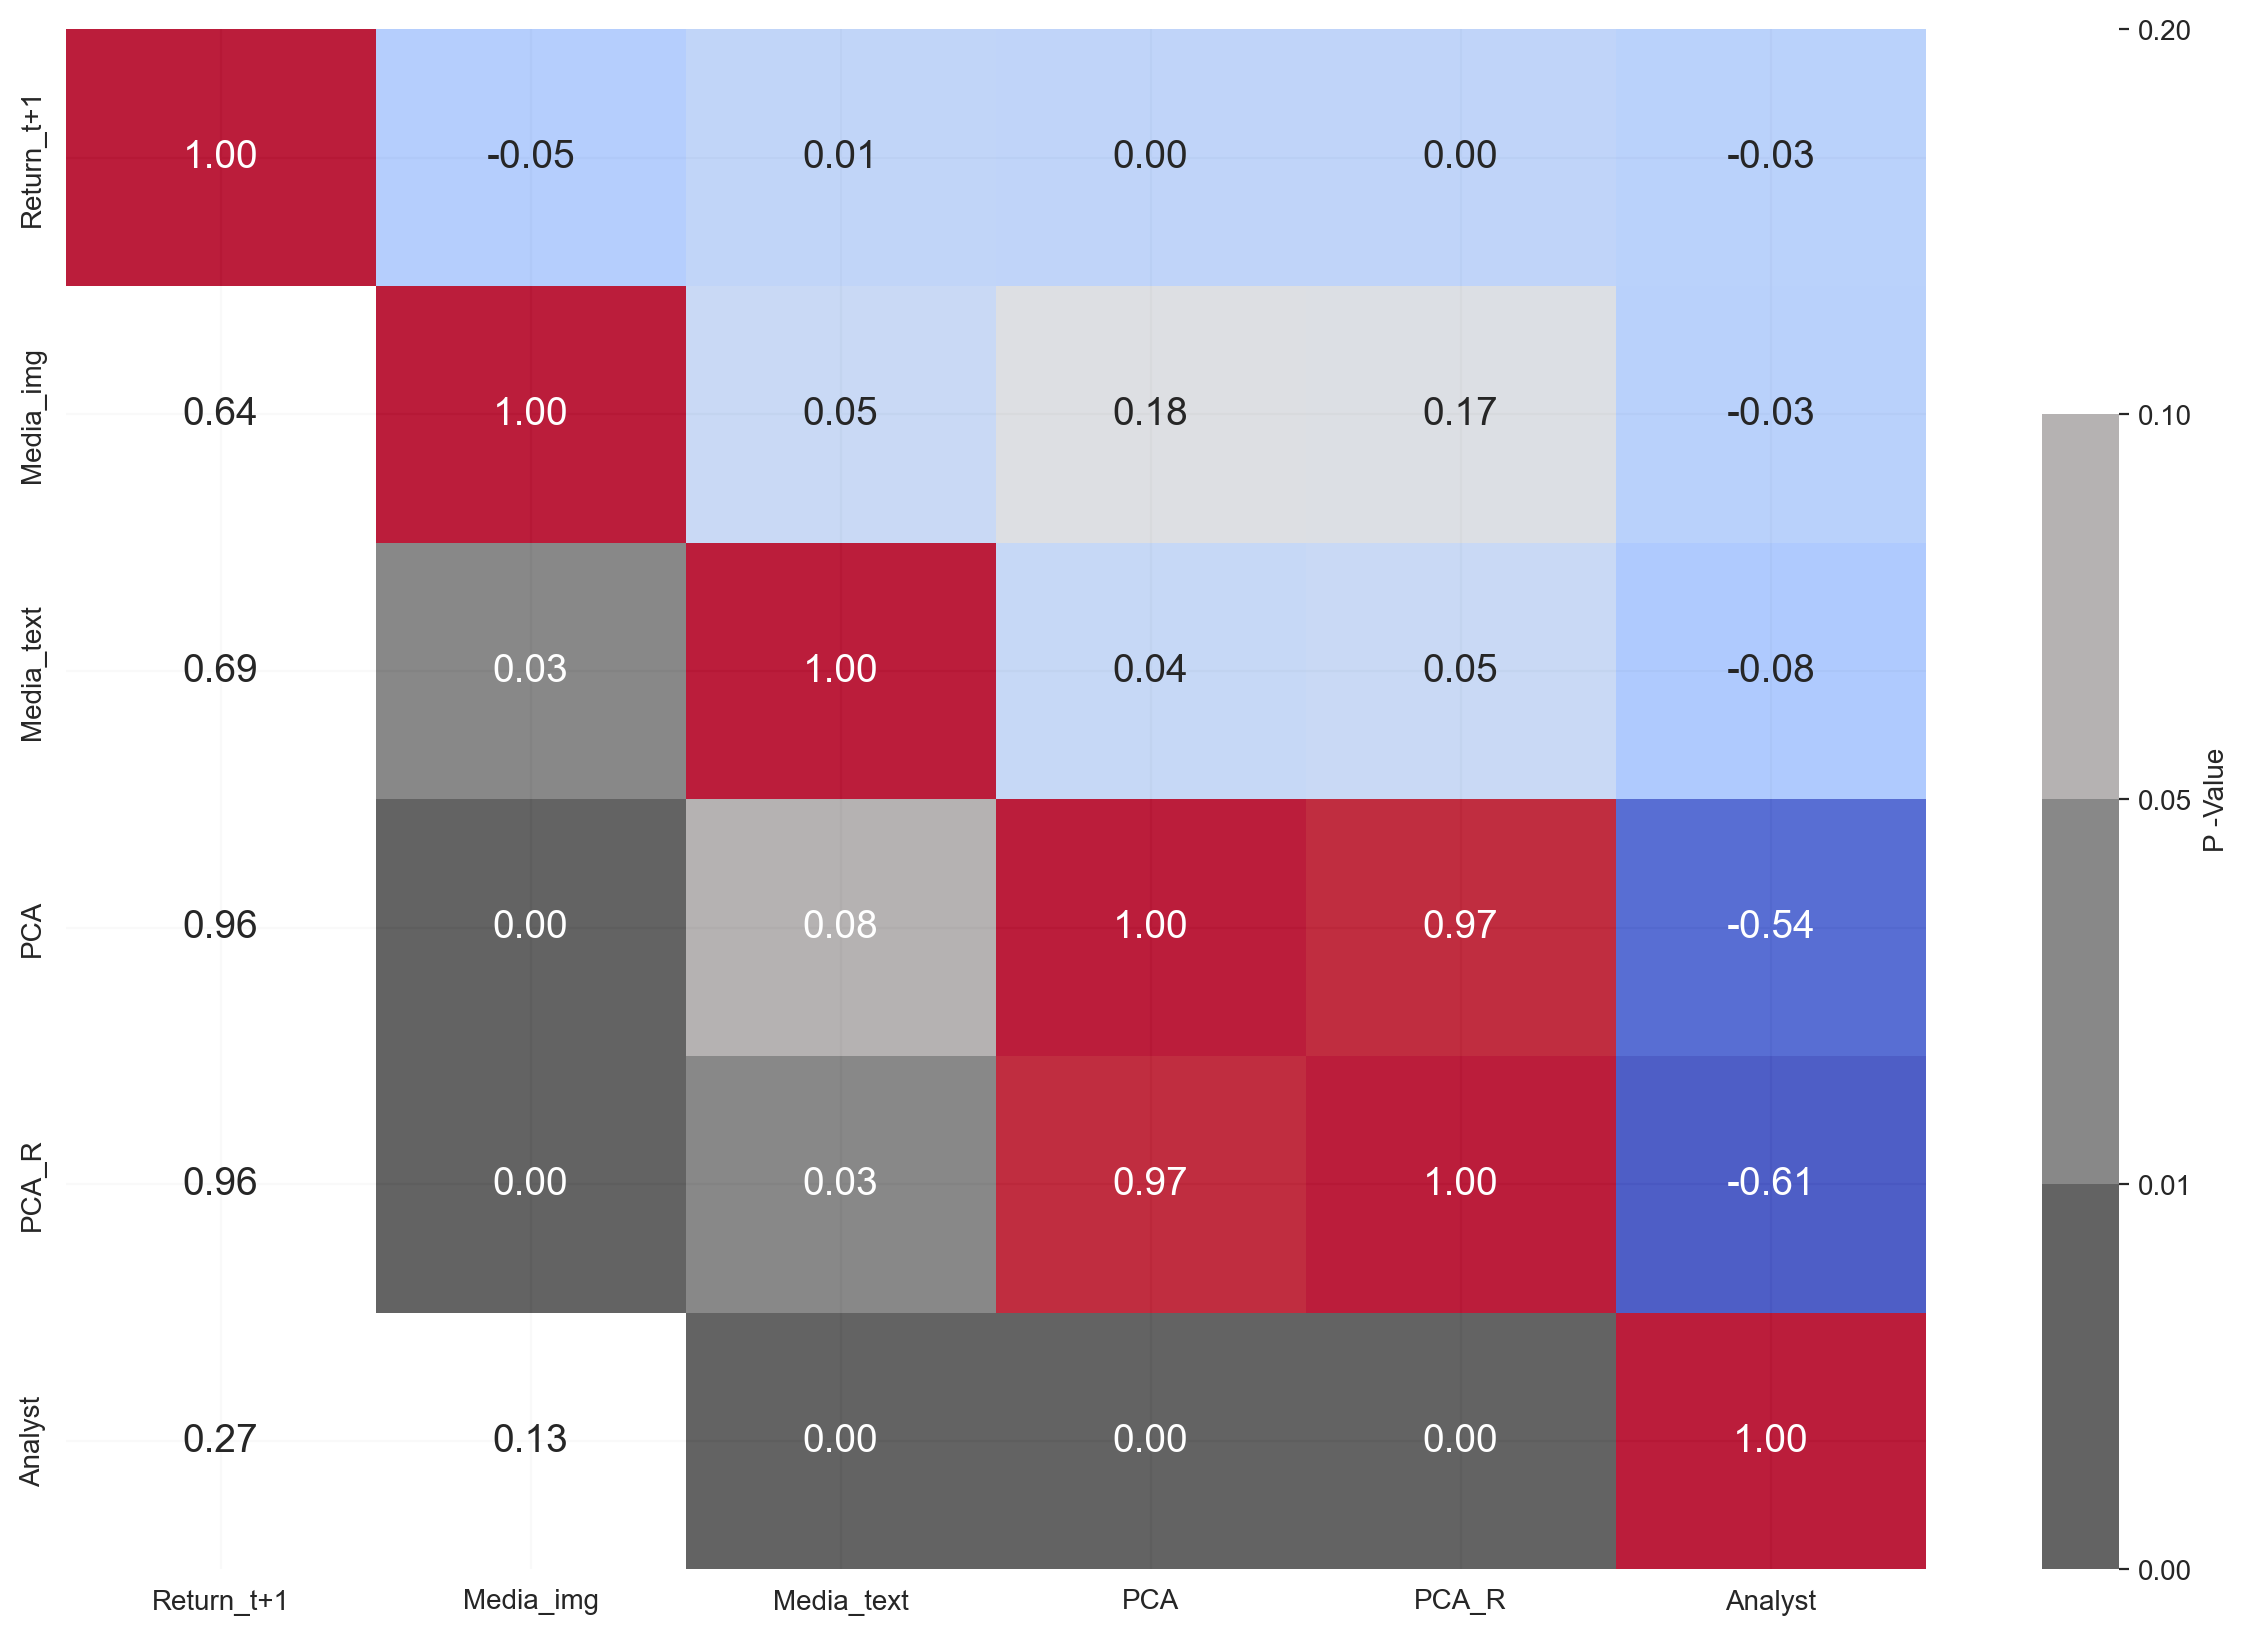

In [25]:
# 计算相关系数矩阵
corr_matrix = df.corr().copy()

# 显著性矩阵
p_values = pd.read_csv('outputs/sentindex_pwcorr_t.csv').drop(columns=['Unnamed: 0']).to_numpy()

# 将下三角矩阵的元素替换为NaN
p_values = np.tril(p_values, k=-1)
p_values[p_values == 0] = np.nan

# 将p值矩阵转换为数据框
p_values = pd.DataFrame(p_values, index=corr_matrix.index, columns=corr_matrix.columns)

# 定义颜色映射和范围
colors = ['#525252', '#7B7B7B', '#ADAAAA', '#FFFFFF', ]
bounds = [0, 0.01, 0.05, 0.1, 0.2]
cmap = sns.color_palette(colors, n_colors=len(bounds) - 1)
norm = BoundaryNorm(bounds, len(bounds) - 1)

# 设置图像大小和dpi
plt.figure(figsize=(15, 10), dpi=200)

# 绘制热力图
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=p_values.notnull(), alpha=0.9, cbar=False,
            cbar_kws={"label": "Person"}, annot_kws={"fontsize": 14})
sns.heatmap(p_values, annot=True, fmt='.2f', cmap=cmap, norm=norm, mask=p_values.isnull(), alpha=0.9, cbar=True,
            cbar_kws={"label": "P -Value"}, annot_kws={"fontsize": 14})
plt.show()

### 样本内回归和样本外预测

In [26]:
# @formatter:off

In [27]:
%%stata -d df_is -force
/*{*/
//清除估计结果
est clear

//生成时间变量 (已排序)
ge date=_n
tsset date

// 划分训练集和测试集
ge byte in_train = (date < 1944*0.8)
ge byte in_test = (date >= 1944*0.8)

//计算测试集中因变量的均值
egen mean_close_chg = mean(close_chg) if in_test

//计算实际值与均值之间的平方差异的总和
egen sum_sq_diff_mean = total((close_chg - mean_close_chg)^2) if in_test

//计算基准模型预测误差
ge error_benchmark = close_chg - mean_close_chg if in_test

//定义待对比的指标
local independent_vars "img_neg tex_neg SENT_INDEX_EX SENT_INDEX_R_EX opt_profit"

//循环
foreach var of local independent_vars{

        //1.样本外OOS R2

        //使用训练集进行线性回归建模 滞后1期
        eststo `var': reg close_chg l.`var' if in_train
        scalar coef = e(b)[1, 1]
        estadd scalar coef
        scalar tstat = e(b)[1, 1]/(sqrt(e(V)[1, 1]))
        estadd scalar tstat

        //进行样本外预测,线性预测值
        predict pred_`var' if in_test

        //计算MSPE
        egen mspe_`var' = mean((close_chg - pred_`var')^2) if in_test /*{*/
        qui sum mspe_`var' if in_test
        scalar mspe = r(mean)
        estadd scalar mspe

        //计算实际值与预测值之间的平方差异的总和
        egen sum_sq_diff_pred_`var' = total((close_chg - pred_`var')^2) if in_test

        //计算样本外 R-squared (OOS R2)
        ge oos_r2_`var' = 1 - (sum_sq_diff_pred_`var' / sum_sq_diff_mean) if in_test
        qui sum oos_r2_`var' if in_test
        scalar oos_r2 = r(mean)
        estadd scalar oos_r2

        //2.CW测试

        // 计算预测误差
        ge error_`var' = close_chg - pred_`var' if in_test

        //计算误差差值(Error differences)
        ge error_diff_`var' = error_`var'^2 - error_benchmark^2 if in_test

        //使用误差差值执行线性回归
        reg error_diff_`var' l.error_diff_`var' if in_test

}



. /*{*/
. //清除估计结果
. est clear

. 
. //生成时间变量 (已排序)
. ge date=_n

. tsset date

Time variable: date, 1 to 1944
        Delta: 1 unit

. 
. // 划分训练集和测试集
. ge byte in_train = (date < 1944*0.8)

. ge byte in_test = (date >= 1944*0.8)

. 
. //计算测试集中因变量的均值
. egen mean_close_chg = mean(close_chg) if in_test
(1,555 missing values generated)

. 
. //计算实际值与均值之间的平方差异的总和
. egen sum_sq_diff_mean = total((close_chg - mean_close_chg)^2) if in_test
(1,555 missing values generated)

. 
. //计算基准模型预测误差
. ge error_benchmark = close_chg - mean_close_chg if in_test
(1,555 missing values generated)

. 
. //定义待对比的指标
. local independent_vars "img_neg tex_neg SENT_INDEX_EX SENT_INDEX_R_EX opt_pro
> fit"

. 
. //循环
. foreach var of local independent_vars{
  2. 
.         //1.样本外OOS R2
. 
.         //使用训练集进行线性回归建模 滞后1期
.         eststo `var': reg close_chg l.`var' if in_train
  3.         scalar coef = e(b)[1, 1]
  4.         estadd scalar coef
  5.         scalar tstat = e(b)[1, 1]/(sqrt(e(V)[1, 1]))
  6.     

In [28]:
%%stata
ereturn list
esttab ,star(* 0.1 ** 0.05 *** 0.01)  scalars(coef tstat r2 mspe oos_r2)
mat R = r(stats)'
esttab mat(R) using outputs/sentindex_compare,r nomtitle nogaps compress


. ereturn list

scalars:
                  e(N) =  388
               e(df_m) =  1
               e(df_r) =  386
                  e(F) =  6.242076148190041
                 e(r2) =  .0159138361939318
               e(rmse) =  .0514399688162567
                e(mss) =  .0165169728791956
                e(rss) =  1.021383171241538
               e(r2_a) =  .0133643901737089
                 e(ll) =  601.782279771622
               e(ll_0) =  598.6701665131624
               e(rank) =  2

macros:
            e(cmdline) : "regress error_diff_opt_profit l.error_diff_opt_pr.."
              e(title) : "Linear regression"
          e(marginsok) : "XB default"
                e(vce) : "ols"
             e(depvar) : "error_diff_opt_profit"
                e(cmd) : "regress"
         e(properties) : "b V"
            e(predict) : "regres_p"
              e(model) : "ols"
          e(estat_cmd) : "regress_estat"

matrices:
                  e(b) :  1 x 2
                  e(V) :  2 x 2
       

## 第三章 情绪对股票市场影响的实证研究

In [29]:
df_is.columns

Index(['Unnamed: 0', 'trade_date', 'ts_code', 'CON_YEAR', 'CON_OR', 'CON_NP',
       'CON_EPS', 'CON_NA', 'CON_PB', 'CON_PS', 'CON_PE', 'CON_PEG', 'CON_ROE',
       'CON_OR_YOY', 'CON_NP_YOY', 'CON_NPCGRATE_2Y', 'CON_PEI', 'trade_year',
       'profit', 'year_profit', 'year_pe_ttm', 'year_profit_l1',
       'year_profit_yoy', 'code_name', 'close', 'pe_ttm_weight',
       'pe_ttm_equal', 'pb_ttm_weight', 'pb_ttm_equal', 'div_rate', 'roe',
       'profit_avg', 'mv_avg', 'float_mv', 'total_mv', 'total_mv_l1',
       'total_mv_chg', 'close_l1', 'close_chg', 'img_neg', 'tex_neg',
       'riskfree_return', 'opt_profit_yoy', 'opt_pe', 'opt_profit', 'time',
       'close_chg_s', 'CEFD', 'RIPO', 'NIPO', 'TURN', 'TURN_MA', 'trade_month',
       'SR', 'lnPD', 'c_yoy', 'p_yoy', 'n', 'l1_TURN', 'SENT_INDEX', 'CEFD_R',
       'NIPO_R', 'RIPO_R', 'SR_R', 'l1_TURN_R', 'lnPD_R', 'SENT_INDEX_R',
       'SENT_INDEX_EX', 'SENT_INDEX_DEX', 'SENT_INDEX_R_EX',
       'SENT_INDEX_R_DEX'],
      dtype='object'

### 媒体情绪


. /*{*/
. //时间设定
. tsset time

Time variable: time, 1 to 1944
        Delta: 1 unit

. est clear

. 
. //VAR回归
. eststo: var close_chg img_neg close_chg_s, lags(1/5) exog(trade_year trade_mo
> nth)
note: trade_year omitted because of collinearity.

Vector autoregression

Sample: 6 thru 1944                             Number of obs     =      1,939
Log likelihood =  -8382.236                     AIC               =   8.698541
FPE            =   1.203112                     HQIC              =   8.752418
Det(Sigma_ml)  =   1.141457                     SBIC              =   8.845042

Equation           Parms      RMSE     R-sq      chi2     P>chi2
----------------------------------------------------------------
close_chg            17     1.48995   0.0198   39.25336   0.0010
img_neg              17     .143133   0.0442   89.64701   0.0000
close_chg_s          17     5.38798   0.1857   442.0808   0.0000
----------------------------------------------------------------

-------------------

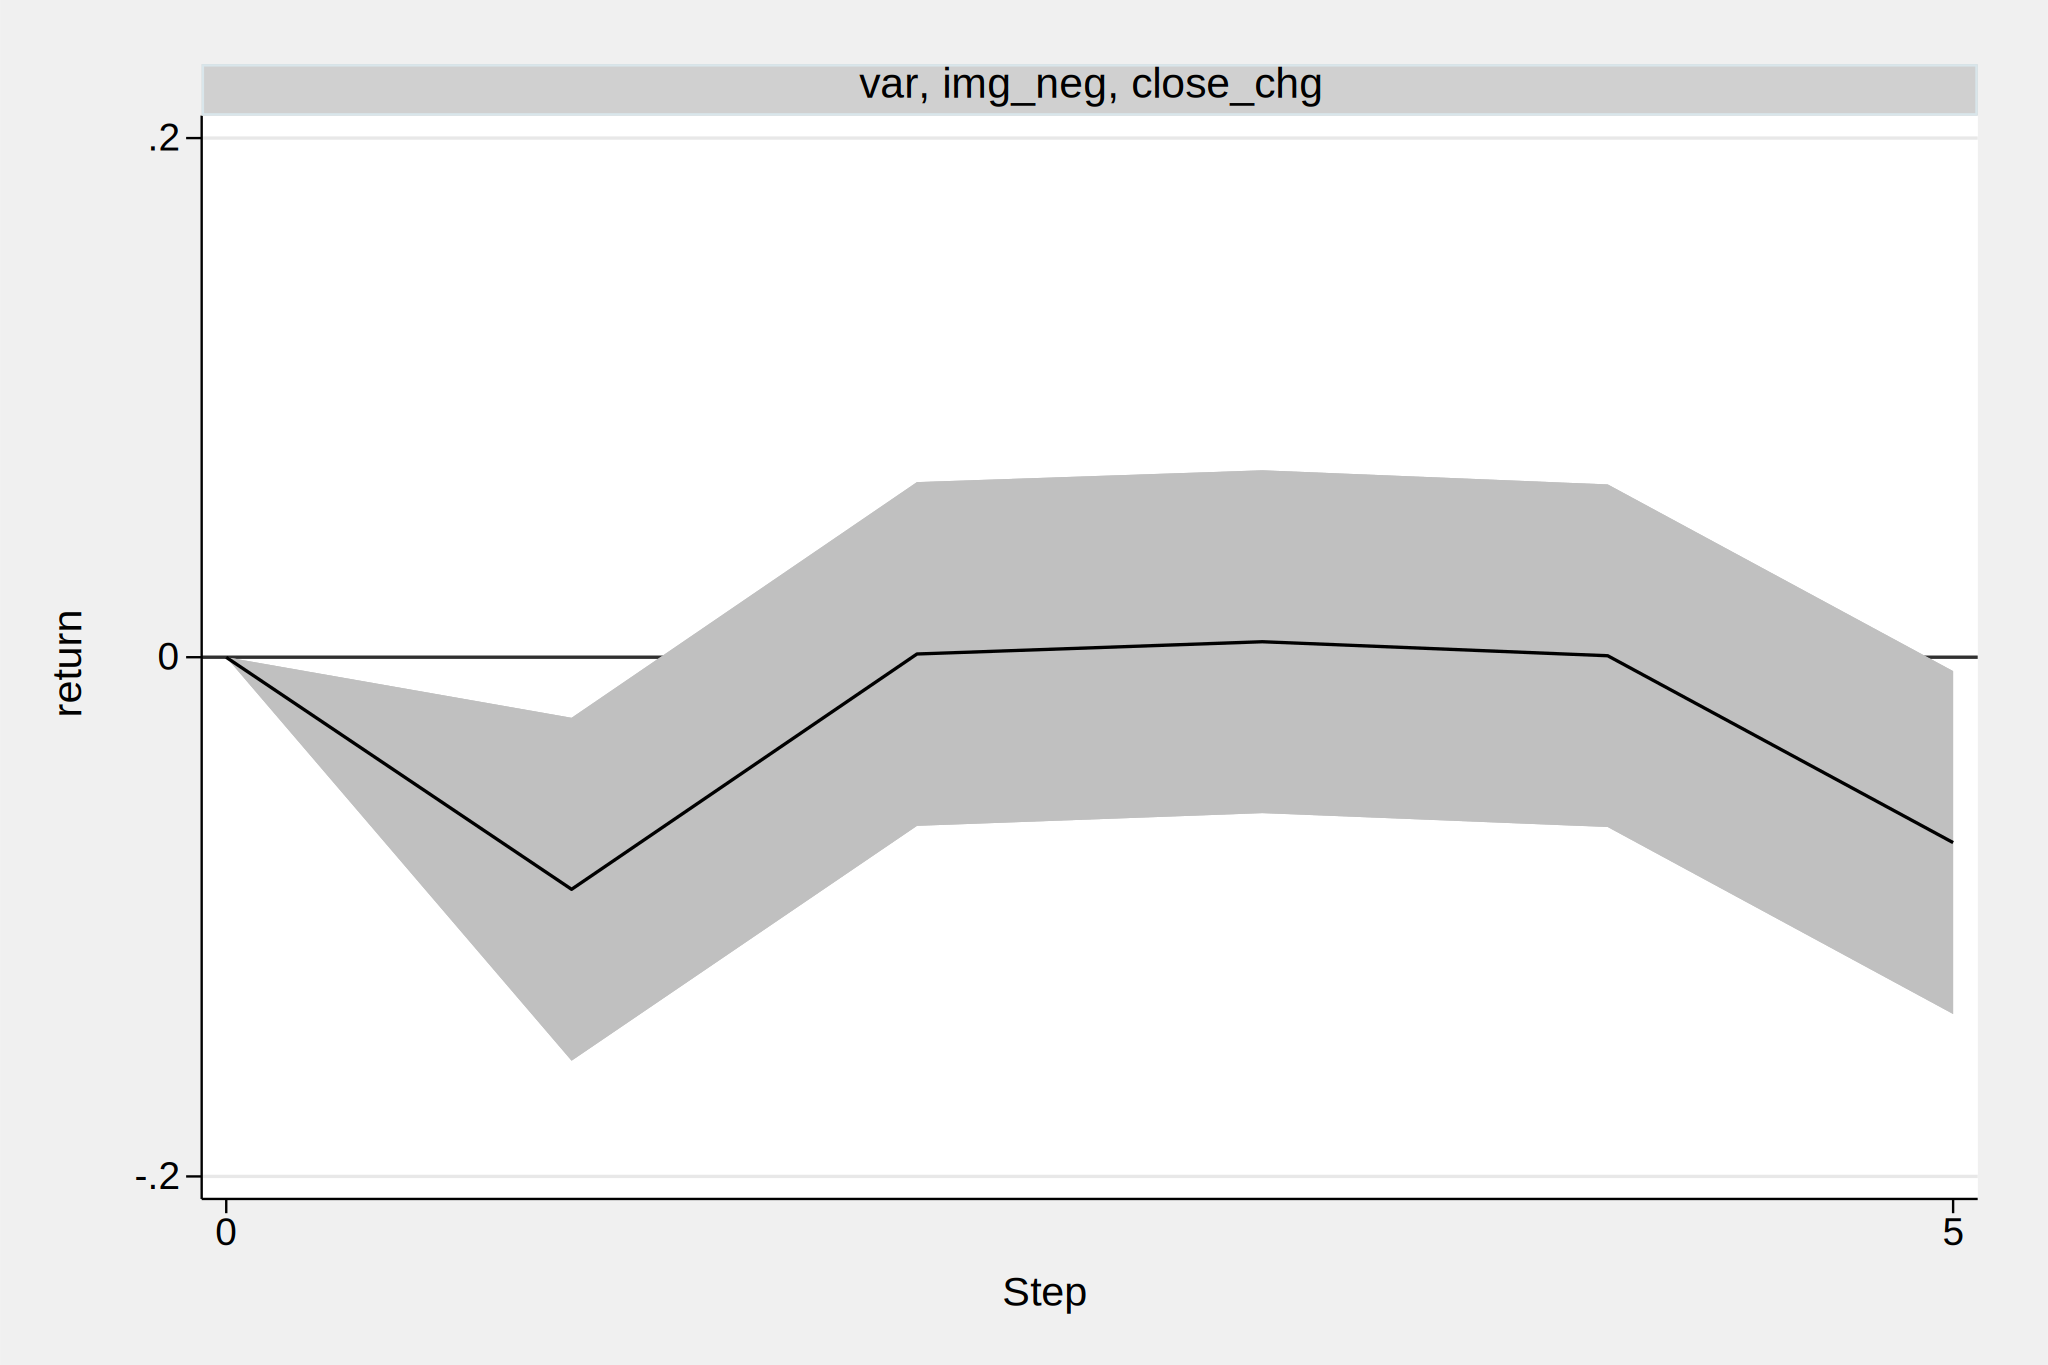

In [30]:
%%stata -d df_is -force -gw 12in -gh 8in
/*{*/
//时间设定
tsset time
est clear

//VAR回归
eststo: var close_chg img_neg close_chg_s, lags(1/5) exog(trade_year trade_month)
estadd local Month "Yes", replace
estadd local Weekday "Yes", replace

// 脉冲响应曲线
/*{*/
irf creat var, set(outputs/var_img ,replace) step(5)
irf graph oirf, impulse(img_neg) response(close_chg) lstep(0) ustep(5)  name(var_img,replace) ///
byopts(note("")) byopts(legend(off)) xtitle(, size(small) margin(zero)) ///
ysc(r(-0.15,0.15)) yline(0) ylabel(#2) ytitle(return, size(small) margin(zero)) scheme(sj)

/*{*/
//输出
esttab , keep(close_chg:L*.img_neg) ///
star(* 0.1 ** 0.05 *** 0.01) ///
stats( Month Weekday  r2_1 N, fmt(%3s %3s %12.4f %12.0f)) b(%12.4f) nogap